In [7]:
# --- 1. Impor Semua Library yang Dibutuhkan ---
import pandas as pd
import numpy as np # Pastikan numpy terimpor untuk operasi sMAPE
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns # Pastikan seaborn terimpor untuk visualisasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

Data latih dan uji berhasil dimuat.
Skenario 5: Fitur Dasar + SEMUA Fitur Lag yang Tersedia (spesifik dan agregasi)

Jumlah fitur yang digunakan: 44

Mulai melatih model LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8333
[LightGBM] [Info] Number of data points in the train set: 262880, number of used features: 44
[LightGBM] [Info] Start training from score 13.289391
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3506]	valid_0's l1: 1.71678

Model berhasil dilatih!

Menampilkan Feature Importance...


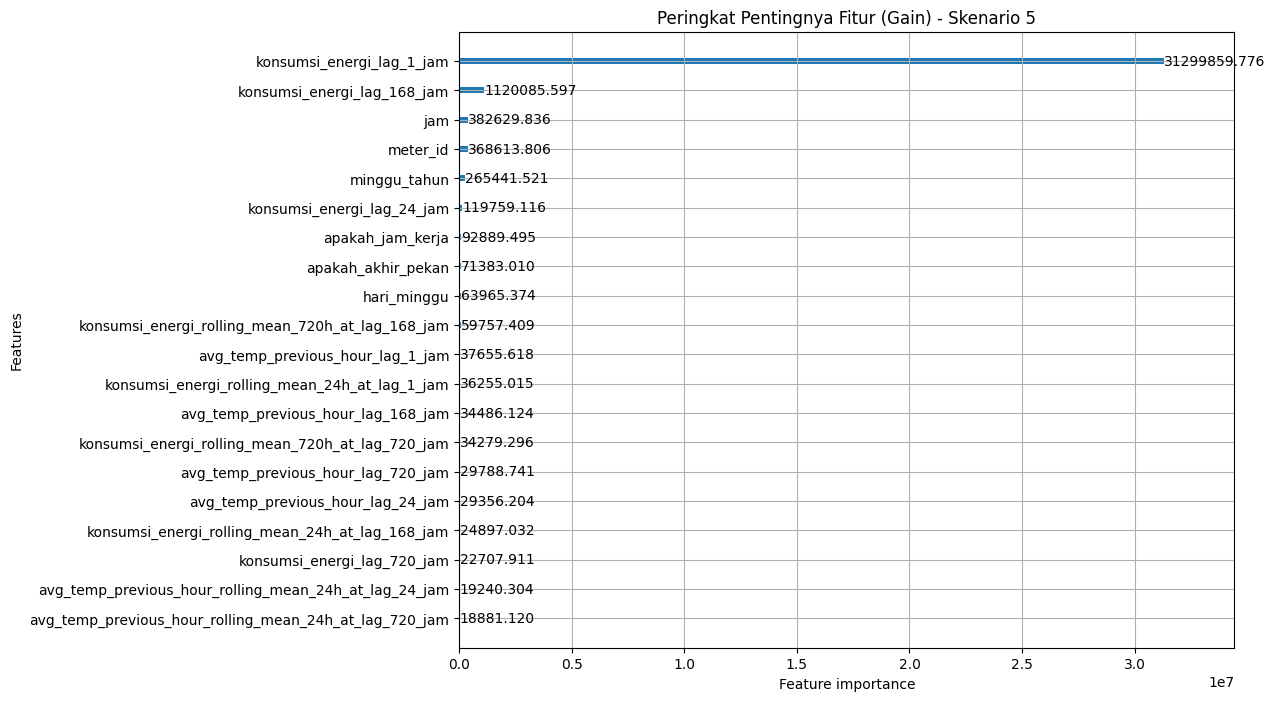


--- Hasil Evaluasi Model (Komprehensif) ---
Mean Absolute Error (MAE): 1.72
Root Mean Square Error (RMSE): 4.44
Symmetric Mean Absolute Percentage Error (sMAPE): 15.09%
R-squared (R²): 0.97

Interpretasi:
- Rata-rata, prediksi model meleset sebesar 1.72 kWh dari nilai sebenarnya.
- Rata-rata, persentase kesalahan prediksi (sMAPE) adalah 15.09%.
- Model dapat menjelaskan sekitar 97% dari variasi konsumsi energi.

Berhasil menyimpan hasil lengkap LightGBM (termasuk data aktual dan prediksi).


In [11]:
# ==============================================================================
# LANGKAH 1: PANEL KONTROL EKSPERIMEN (LOGIKA BARU)
# ==============================================================================
# PILIH NOMOR SKENARIO UNTUK MENENTUKAN KUMPULAN FITUR YANG DIGUNAKAN:
#
# Skenario 1: Fitur Dasar + Semua Fitur Lag dari 1 Jam dan yang lebih panjang
#             (mencakup lag 1 jam, 24 jam, 1 minggu, 1 bulan,
#              serta semua fitur rata-rata yang di-lag yang terkait dengan periode tersebut).
#
# Skenario 2: Fitur Dasar + Semua Fitur Lag dari 24 Jam dan yang lebih panjang
#             (mengecualikan lag 1 jam dan agregasi terkait. Hanya menggunakan lag 24 jam,
#              1 minggu, 1 bulan, dan agregasinya).
#
# Skenario 3: Fitur Dasar + Semua Fitur Lag dari 1 Minggu dan yang lebih panjang
#             (mengecualikan lag 1 jam dan 24 jam beserta agregasinya.
#              Hanya menggunakan lag 1 minggu, 1 bulan, dan agregasinya).
#
# Skenario 4: Fitur Dasar + Semua Fitur Lag dari 1 Bulan
#             (mengecualikan semua fitur lag yang lebih pendek dari 1 bulan.
#              Hanya menggunakan lag 1 bulan dan agregasinya).
#
# Skenario 5: Fitur Dasar + SEMUA Fitur Lag yang Tersedia (spesifik dan agregasi).
#
PILIHAN_SKENARIO = 5  # <-- UBAH ANGKA INI (1-5)

TARGET = 'konsumsi_energi' # Mendefinisikan TARGET lebih awal agar dapat diakses di seluruh script


# ==============================================================================
# LANGKAH 2: MEMUAT DATA
# ==============================================================================
path_split_data = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\split_data'
# Memuat dataset_final_features_spatio_temporal.parquet yang sudah memiliki fitur baru
train_set = pd.read_parquet(os.path.join(path_split_data, 'train_set.parquet'))
test_set = pd.read_parquet(os.path.join(path_split_data, 'test_set.parquet'))
print("Data latih dan uji berhasil dimuat.")

# ==============================================================================
# LANGKAH 3: PENDEFINISIAN BLOK-BLOK FITUR (DENGAN UPDATE)
# ==============================================================================

# Definisikan fitur-fitur yang akan digunakan dalam model LightGBM
# Fitur dasar sekarang mencakup jenis gedung
features_base = [
    'jam', 'hari_minggu', 'hari_bulan', 'minggu_tahun', 'bulan', 'tahun',
    'apakah_akhir_pekan', 'apakah_jam_kerja', 'meter_id',
    'is_kelas', 'is_kantor', 'is_penelitian'
]

# Definisikan kelompok fitur lag spesifik dan agregasi yang di-lag
# Ini sesuai dengan output dari script feature_engineering_spatiotemporal
features_group_1h = [
    'konsumsi_energi_lag_1_jam', 'avg_temp_previous_hour_lag_1_jam',
    'konsumsi_energi_rolling_mean_24h_at_lag_1_jam', 'avg_temp_previous_hour_rolling_mean_24h_at_lag_1_jam',
    'konsumsi_energi_rolling_mean_168h_at_lag_1_jam', 'avg_temp_previous_hour_rolling_mean_168h_at_lag_1_jam',
    'konsumsi_energi_rolling_mean_720h_at_lag_1_jam', 'avg_temp_previous_hour_rolling_mean_720h_at_lag_1_jam'
]

features_group_24h = [
    'konsumsi_energi_lag_24_jam', 'avg_temp_previous_hour_lag_24_jam',
    'konsumsi_energi_rolling_mean_24h_at_lag_24_jam', 'avg_temp_previous_hour_rolling_mean_24h_at_lag_24_jam',
    'konsumsi_energi_rolling_mean_168h_at_lag_24_jam', 'avg_temp_previous_hour_rolling_mean_168h_at_lag_24_jam',
    'konsumsi_energi_rolling_mean_720h_at_lag_24_jam', 'avg_temp_previous_hour_rolling_mean_720h_at_lag_24_jam'
]

features_group_1w = [
    'konsumsi_energi_lag_168_jam', 'avg_temp_previous_hour_lag_168_jam',
    'konsumsi_energi_rolling_mean_24h_at_lag_168_jam', 'avg_temp_previous_hour_rolling_mean_24h_at_lag_168_jam',
    'konsumsi_energi_rolling_mean_168h_at_lag_168_jam', 'avg_temp_previous_hour_rolling_mean_168h_at_lag_168_jam',
    'konsumsi_energi_rolling_mean_720h_at_lag_168_jam', 'avg_temp_previous_hour_rolling_mean_720h_at_lag_168_jam'
]

features_group_1m = [
    'konsumsi_energi_lag_720_jam', 'avg_temp_previous_hour_lag_720_jam',
    'konsumsi_energi_rolling_mean_24h_at_lag_720_jam', 'avg_temp_previous_hour_rolling_mean_24h_at_lag_720_jam',
    'konsumsi_energi_rolling_mean_168h_at_lag_720_jam', 'avg_temp_previous_hour_rolling_mean_168h_at_lag_720_jam',
    'konsumsi_energi_rolling_mean_720h_at_lag_720_jam', 'avg_temp_previous_hour_rolling_mean_720h_at_lag_720_jam'
]

# Definisikan fitur kategorikal secara eksplisit untuk LightGBM
# Ini penting untuk model untuk memperlakukan 'meter_id' sebagai variabel kategori
categorical_features = ['meter_id', 'hari_minggu', 'bulan', 'minggu_tahun', 'tahun']
# Tambahkan juga fitur biner sebagai kategori agar tidak diperlakukan sebagai numerik
categorical_features.extend(['apakah_akhir_pekan', 'apakah_jam_kerja', 'is_kelas', 'is_kantor', 'is_penelitian'])


# ==============================================================================
# LANGKAH 4: LOGIKA PEMILIHAN FITUR SECARA OTOMATIS
# ==============================================================================
SELECTED_FEATURES = features_base.copy()

# Skenario baru yang lebih merepresentasikan pemilihan "lag dari periode ini dan yang lebih panjang"
# serta skenario untuk semua fitur.
if PILIHAN_SKENARIO == 1:
    print("Skenario 1: Fitur Dasar + Semua Fitur Lag dari 1 Jam dan yang lebih panjang (termasuk agregasi terkait)")
    SELECTED_FEATURES.extend(features_group_1h)
    SELECTED_FEATURES.extend(features_group_24h)
    SELECTED_FEATURES.extend(features_group_1w)
    SELECTED_FEATURES.extend(features_group_1m)
elif PILIHAN_SKENARIO == 2:
    print("Skenario 2: Fitur Dasar + Semua Fitur Lag dari 24 Jam dan yang lebih panjang (termasuk agregasi terkait)")
    # Ini akan mengecualikan lag 1 jam seperti yang Anda tanyakan
    SELECTED_FEATURES.extend(features_group_24h)
    SELECTED_FEATURES.extend(features_group_1w)
    SELECTED_FEATURES.extend(features_group_1m)
elif PILIHAN_SKENARIO == 3:
    print("Skenario 3: Fitur Dasar + Semua Fitur Lag dari 1 Minggu dan yang lebih panjang (termasuk agregasi terkait)")
    SELECTED_FEATURES.extend(features_group_1w)
    SELECTED_FEATURES.extend(features_group_1m)
elif PILIHAN_SKENARIO == 4:
    print("Skenario 4: Fitur Dasar + Semua Fitur Lag dari 1 Bulan (termasuk agregasi terkait)")
    SELECTED_FEATURES.extend(features_group_1m)
elif PILIHAN_SKENARIO == 5:
    print("Skenario 5: Fitur Dasar + SEMUA Fitur Lag yang Tersedia (spesifik dan agregasi)")
    # Ini adalah skenario yang akan menggunakan semua fitur
    SELECTED_FEATURES.extend(features_group_1h)
    SELECTED_FEATURES.extend(features_group_24h)
    SELECTED_FEATURES.extend(features_group_1w)
    SELECTED_FEATURES.extend(features_group_1m)
else: # Menggunakan `else` alih-alih `if not` untuk menangani skenario tidak valid
    print(f"Pilihan skenario '{PILIHAN_SKENARIO}' tidak valid. Harap masukkan angka antara 1 dan 5.")
    SELECTED_FEATURES = features_base.copy() # Kembali ke fitur dasar jika skenario tidak valid

print(f"\nJumlah fitur yang digunakan: {len(SELECTED_FEATURES)}")

# ==============================================================================
# LANGKAH 5: PERSIAPAN AKHIR DAN PELATIHAN MODEL
# ==============================================================================
# Konversi `meter_id` dan fitur kategorikal lainnya ke tipe 'category'
# Ini perlu dilakukan untuk train_set dan test_set secara terpisah
for col in categorical_features:
    if col in train_set.columns:
        train_set[col] = train_set[col].astype('category')
    if col in test_set.columns:
        test_set[col] = test_set[col].astype('category')

X_train = train_set[SELECTED_FEATURES]
y_train = train_set[TARGET]
X_test = test_set[SELECTED_FEATURES]
y_test = test_set[TARGET]

model = lgb.LGBMRegressor(
    objective='regression_l1', # Menggunakan MAE sebagai objective
    n_estimators=10000,
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,
    seed=42
)

print("\nMulai melatih model LightGBM...")

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='mae', # Metrik evaluasi untuk early stopping
          callbacks=[lgb.early_stopping(100, verbose=True)],
          # Memberi tahu LightGBM kolom mana yang merupakan fitur kategorikal
          categorical_feature=[col for col in categorical_features if col in X_train.columns]
)

print("\nModel berhasil dilatih!")

# ==============================================================================
# LANGKAH 6: ANALISIS FEATURE IMPORTANCE
# ==============================================================================
print("\nMenampilkan Feature Importance...")
# Menggunakan importance_type='gain' yang seringkali lebih relevan untuk interpretasi
lgb.plot_importance(model, figsize=(10, 8), max_num_features=20, importance_type='gain')
plt.title(f"Peringkat Pentingnya Fitur (Gain) - Skenario {PILIHAN_SKENARIO}")
plt.show()

# --- 7. Evaluasi Model ---
# Fungsi untuk menghitung sMAPE yang lebih stabil
def calculate_smape(y_true, y_pred):
    """Menghitung Symmetric Mean Absolute Percentage Error (sMAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Hitung pembilang dan penyebut
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Hindari pembagian dengan nol jika keduanya (aktual & prediksi) adalah nol
    ratio = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    
    return np.mean(ratio) * 100

# Buat prediksi pada data uji
predictions = model.predict(X_test)

# Hitung metrik evaluasi
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
smape = calculate_smape(y_test, predictions) # Hitung sMAPE

print("\n--- Hasil Evaluasi Model (Komprehensif) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

print("\nInterpretasi:")
print(f"- Rata-rata, prediksi model meleset sebesar {mae:.2f} kWh dari nilai sebenarnya.")
print(f"- Rata-rata, persentase kesalahan prediksi (sMAPE) adalah {smape:.2f}%." )
print(f"- Model dapat menjelaskan sekitar {r2:.0%} dari variasi konsumsi energi.")

# --- 8. Menyimpan Hasil Lengkap Model ---
# Definisikan path untuk menyimpan file
path_output = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\predictions'
os.makedirs(path_output, exist_ok=True) # Membuat folder jika belum ada

# Variabel yang perlu disimpan adalah 'results' DataFrame dari Langkah 8
# DataFrame ini sudah berisi semua informasi yang kita butuhkan.
# Kita hanya perlu mengganti nama kolom prediksi agar spesifik untuk model ini.
results_lgbm_to_save = results.rename(columns={'prediksi': 'prediksi_lgbm'})

# Simpan DataFrame hasil yang sudah lengkap
results_lgbm_to_save.to_parquet(os.path.join(path_output, 'lgbm_results.parquet'), index=False)

print("\nBerhasil menyimpan hasil lengkap LightGBM (termasuk data aktual dan prediksi).")


In [6]:
# --- 4. Evaluasi Model ---

# Fungsi untuk menghitung sMAPE yang lebih stabil
def calculate_smape(y_true, y_pred):
    """Menghitung Symmetric Mean Absolute Percentage Error (sMAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Hitung pembilang dan penyebut
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Hindari pembagian dengan nol jika keduanya (aktual & prediksi) adalah nol
    ratio = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    
    return np.mean(ratio) * 100

# Buat prediksi pada data uji
predictions = model.predict(X_test)

# Hitung metrik evaluasi
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
smape = calculate_smape(y_test, predictions) # Hitung sMAPE

print("\n--- Hasil Evaluasi Model (Komprehensif) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

print("\nInterpretasi:")
print(f"- Rata-rata, prediksi model meleset sebesar {mae:.2f} kWh dari nilai sebenarnya.")
print(f"- Rata-rata, persentase kesalahan prediksi (sMAPE) adalah {smape:.2f}%.")
print(f"- Model dapat menjelaskan sekitar {r2:.0%} dari variasi konsumsi energi.")



--- Hasil Evaluasi Model (Komprehensif) ---
Mean Absolute Error (MAE): 1.61
Root Mean Square Error (RMSE): 4.26
Symmetric Mean Absolute Percentage Error (sMAPE): 14.86%
R-squared (R²): 0.97

Interpretasi:
- Rata-rata, prediksi model meleset sebesar 1.61 kWh dari nilai sebenarnya.
- Rata-rata, persentase kesalahan prediksi (sMAPE) adalah 14.86%.
- Model dapat menjelaskan sekitar 97% dari variasi konsumsi energi.


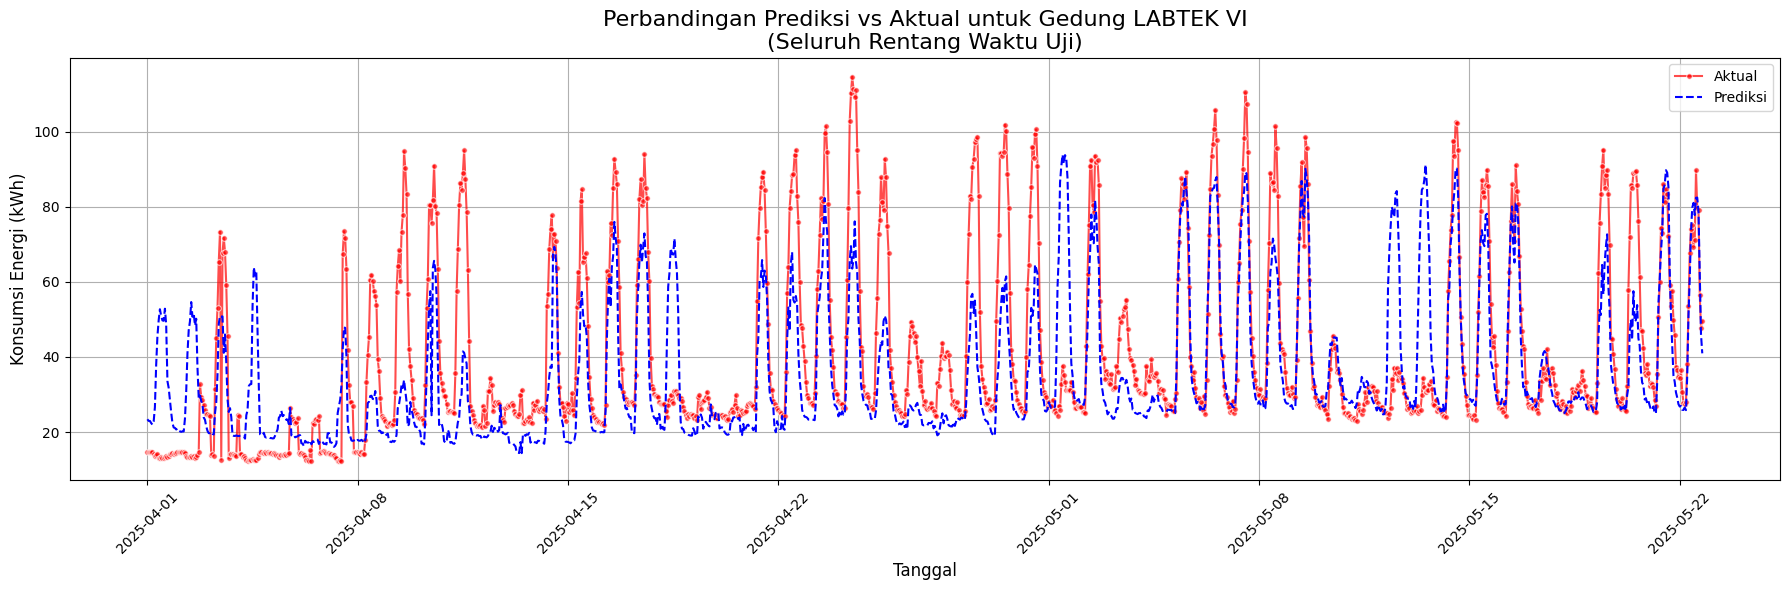

<Figure size 1200x800 with 0 Axes>

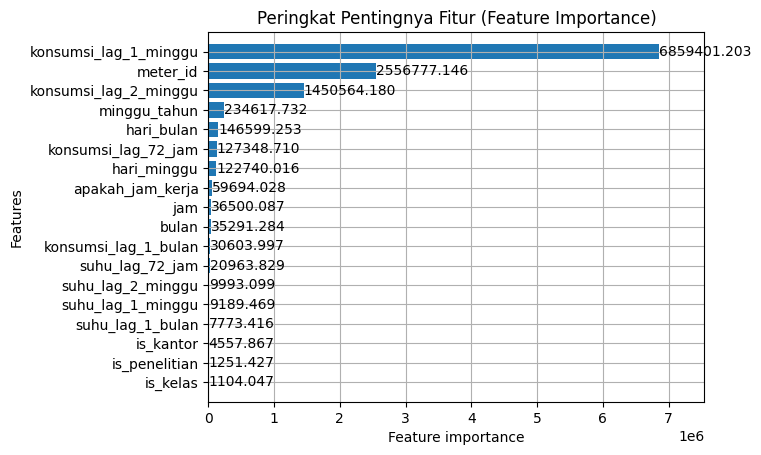

In [28]:
# --- 5. Visualisasi Hasil ---

from mydef import plot_prediksi_vs_aktual
# --- Menggunakan Fungsi Visualisasi ---
# 1. Siapkan DataFrame hasil
results = X_test.copy()
results['target_aktual'] = y_test
results['prediksi'] = predictions
results['timestamp'] = pd.to_datetime(test_set['timestamp'])

# 2. Panggil fungsi untuk melihat hasil (Anda bisa mengubah parameter ini)
plot_prediksi_vs_aktual(results, meter_id_to_plot='LABTEK VI', start_date_str='all', end_date_str='all')
# plot_prediksi_vs_aktual(results, meter_id_to_plot='SBM', start_date_str='2025-04-01', end_date_str='2025-04-08')

# CONTOH 2: Melihat satu gedung spesifik untuk SELURUH rentang waktu uji
# plot_prediksi_vs_aktual(results, meter_id_to_plot='CAS', start_date_str='all', end_date_str='all')

# CONTOH 3: Melihat SEMUA gedung untuk 3 hari pertama (akan menghasilkan banyak plot)
# plot_prediksi_vs_aktual(results, meter_id_to_plot='all', start_date_str='2025-04-01', end_date_str='2025-04-03')


# 3. Plot Pentingnya Fitur (tetap sama)
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.8)
plt.title('Peringkat Pentingnya Fitur (Feature Importance)')
plt.show()

In [8]:
# --- Tambahkan kode ini di akhir notebook LightGBM ---

# Definisikan path untuk menyimpan file
path_output = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\predictions'
os.makedirs(path_output, exist_ok=True) # Membuat folder jika belum ada

# Variabel yang perlu disimpan adalah 'results' DataFrame dari Langkah 3.E
# DataFrame ini sudah berisi semua informasi yang kita butuhkan.
# Kita hanya perlu mengganti nama kolom prediksi agar spesifik untuk model ini.
results_lgbm_to_save = results.rename(columns={'prediksi': 'prediksi_lgbm'})

# Simpan DataFrame hasil yang sudah lengkap
results_lgbm_to_save.to_parquet(os.path.join(path_output, 'lgbm_results.parquet'), index=False)

print("\nBerhasil menyimpan hasil lengkap LightGBM (termasuk data aktual dan prediksi).")



Berhasil menyimpan hasil lengkap LightGBM (termasuk data aktual dan prediksi).


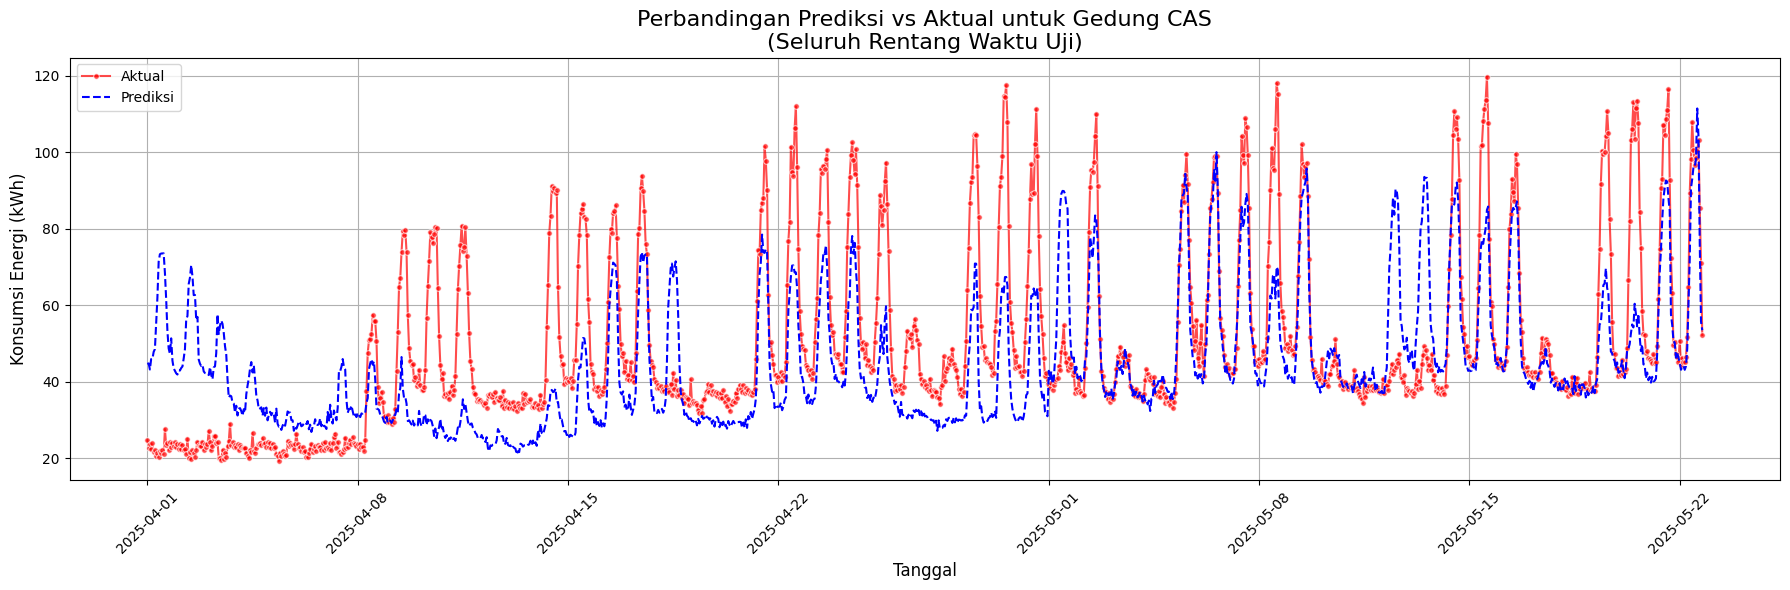

<Figure size 1200x800 with 0 Axes>

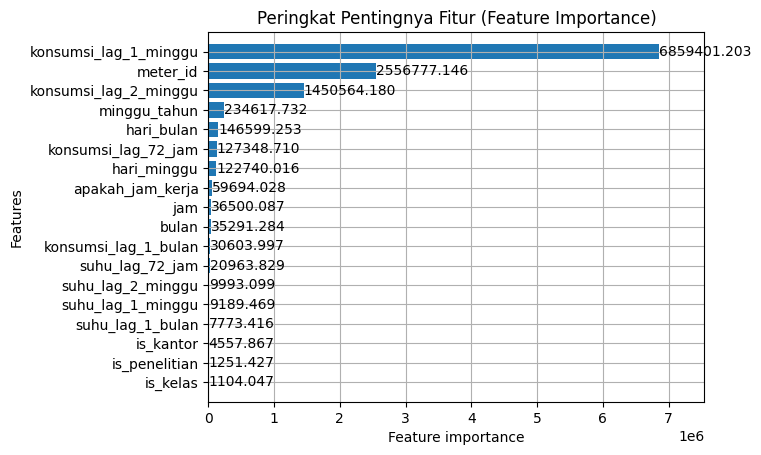

In [29]:
# --- 5. Visualisasi Hasil ---

from mydef import plot_prediksi_vs_aktual
# --- Menggunakan Fungsi Visualisasi ---
# 1. Siapkan DataFrame hasil
results = X_test.copy()
results['target_aktual'] = y_test
results['prediksi'] = predictions
results['timestamp'] = pd.to_datetime(test_set['timestamp'])

# 2. Panggil fungsi untuk melihat hasil (Anda bisa mengubah parameter ini)
plot_prediksi_vs_aktual(results, meter_id_to_plot='CAS', start_date_str='all', end_date_str='all')
# plot_prediksi_vs_aktual(results, meter_id_to_plot='SBM', start_date_str='2025-04-01', end_date_str='2025-04-08')

# CONTOH 2: Melihat satu gedung spesifik untuk SELURUH rentang waktu uji
# plot_prediksi_vs_aktual(results, meter_id_to_plot='CAS', start_date_str='all', end_date_str='all')

# CONTOH 3: Melihat SEMUA gedung untuk 3 hari pertama (akan menghasilkan banyak plot)
# plot_prediksi_vs_aktual(results, meter_id_to_plot='all', start_date_str='2025-04-01', end_date_str='2025-04-03')


# 3. Plot Pentingnya Fitur (tetap sama)
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.8)
plt.title('Peringkat Pentingnya Fitur (Feature Importance)')
plt.show()